## 1) Un perceptrón o neurona no es capaz de aproximar una función que separe en dos clases (naranja y azul) el conjunto de datos mostrado en la figura 1. 

## Propón una transformación aplicada a los atributos x1 y x2 de forma que puedan ser separados por solo un perceptrón. Justifica porque la transformación propuesta funciona. 

Los datos asemenjan una frontera de decision circular, si consideramos un circulo unitario podemos representar su ecuacion de forma vectorial
$$
g(\vec{x}) =  w_1 x_1^2+ w_2 x_2^2+ w_0
$$
Donde:
- $w_1=1$
- $w_2=1$
- $w_0=-radio$

Esta ecuacion no es lineal en el espacio original de $x_1$ y $x_2$, podemos trasladar nuestros datos a otro tipo espacio donde la ecuacion del circulo sea lineal esto lo podemos hacer mediante una transformacion

$$
g(\vec{x}) =  w_1 x_1^2 + w_2 x_2^2+ w_0 = w_1 X_1 + w_2 X_2+ w_0
$$

Se propone la siguiente transformacion para poder separar mejor nuestros datos

$$
\phi(x_1,x_2)\mapsto(x_1^2,x_2^2)
$$

## 2) Extiende el ejercicio 1c reglin.ipynb visto en clase para realizar regresión lineal con los dos atributos de entrada

### Preparación

In [368]:
# sistema de archivos
import os
# gráficas
import matplotlib.pyplot as plt
# csv
import pandas as pd
# redes neuronales
import torch
from torch import tensor
from torch.nn.functional import mse_loss
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
# procesamiento de imágenes
from skimage import io
# redes neuronales
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
# inspección de arquitectura
from torchinfo import summary
# barras de progreso
from tqdm.auto import trange

In [318]:
def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

# reproducibilidad
set_seed()

### Auxiliares

In [3]:
URL = 'https://raw.githubusercontent.com/bereml/iap/master/datos/califs.csv'
base_dir = '../datos'
filename = 'califs.csv'
filepath = os.path.join(base_dir, filename)

In [370]:
# directorio de datos
DATA_DIR = '../datos'
# tamaño del lote
BATCH_SIZE = 32

### Datos

Descargamos los datos.

In [4]:
! mkdir {base_dir}
! wget -nc {URL} -O {filepath}

mkdir: no se puede crear el directorio «../datos»: El fichero ya existe
El fichero «../datos/califs.csv» ya está ahí, no se recupera.


Utilizamos para la lectura del csv e imprimimos los primeros 5 ejemplos.

In [347]:
df = pd.read_csv(filepath)
df.head(5)

,prev,horas,calif
0,5.6,8.2,5.1
1,6.7,9.3,5.9
2,5.1,10.0,5.4
3,5.7,10.4,6.5
4,7.1,10.4,6.7


Obtengamos el atributo y la salida:

In [44]:
x = torch.tensor(df.iloc[:, :2].values)
x = x.view(-1, 2).type(torch.float32)
print(x.shape)
x[:5]

torch.Size([50, 2])


tensor([[ 5.6000,  8.2000],
        [ 6.7000,  9.3000],
        [ 5.1000, 10.0000],
        [ 5.7000, 10.4000],
        [ 7.1000, 10.4000]])

In [45]:
y_true = torch.tensor(df.iloc[:, 2].values)
y_true = y_true.view(-1, 1).type(torch.float32)
print(y_true.shape)
y_true[:5]

torch.Size([50, 1])


tensor([[5.1000],
        [5.9000],
        [5.4000],
        [6.5000],
        [6.7000]])

In [46]:
# número de ejemplos y atributos
m, d = x.shape
m, d

(50, 2)

Grafiquemos para tener una idea de la distribución de los datos:

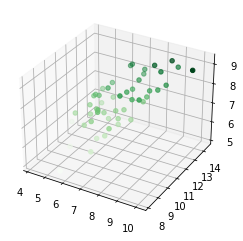

In [53]:
from mpl_toolkits import mplot3d

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
X,Y,Z= df["prev"], df["horas"], df["calif"]
ax.scatter3D(X,Y,Z, c=Z, cmap='Greens')

### Hipótesis

Recordemos que dado un conjunto de ejemplos con atributos ($x_1, \dots, x_d$) y salidas $y$, la hipótesis de regresión lineal considerando un plano está dada por:

$$\hat{y} =  x_1 w_1 + \dots + x_d w_d + b$$

donde $w_i$ y $b$ son pesos y sesgo (parámetros) del modelo y $\hat{y}$ la salida predicha. Podemos expresar la hipótesis en su forma vectorial como:

$$\hat{y} =  x w + b$$

Nuestro trabajo consiste en estimar (aprender) los parámetros $w_i$ y $b$. Por el momento supongamos que proponemos valores para los parámetros y hagamos inferencia:

### Función de pérdida

La pérdida para este modelo es el error cuadrático medio y queda expresado de la siguiente manera:

$$ J(w, b) = \frac{1}{2m}  \sum_{i=1}^{m}{(\hat{y}^{(i)} - y^{(i)})^2} $$

en su forma vectorial:

$$ J(w, b) = \frac{1}{2m} (\hat{y} - y)^T (\hat{y} - y) $$


In [356]:
x=torch.from_numpy(df[["prev","horas"]].values)
x=x.float()
x.shape

torch.Size([50, 2])

In [357]:
y=torch.from_numpy(df["calif"].values)
y.shape

torch.Size([50])

In [358]:
def LinearReg(x,w,b):
    #tranpose=torch.transpose(w,0,1)
    return x@w.T+b

Inicilizamos los pesos y el bias de manera aleatoria

In [359]:
w=torch.randn(1,2,requires_grad=True)
b=torch.randn(1,requires_grad=True)

In [360]:
y_pred=LinearReg(x,w,b)
y_true=y.float()
y_true=torch.reshape(y_true, (y_true.shape[0], 1))

In [361]:
print(y_true.shape)
print(y_pred.shape)

torch.Size([50, 1])
torch.Size([50, 1])


In [362]:
loss = (y_pred - y_true).T @ (y_pred - y_true) / (2 * m)
loss

tensor([[0.3450]], grad_fn=<DivBackward0>)

### Descenso por gradiente

![graddes](https://ml-cheatsheet.readthedocs.io/en/latest/_images/gradient_descent_demystified.png)
<div> https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html </div>
&nbsp;

El algoritmo del gradiente descendente se basa en el gradiente de la pérdida respecto de los parámetros:

$$\frac{\partial J(w_j)}{\partial w_j} = \frac{1}{m} \sum_{i=1}^{m}{x^{(i)}_j(\hat{y}^{(i)} - y^{(i)})}$$

$$\frac{\partial J(b)}{\partial b} = \frac{1}{m} \sum_{i=1}^{m}{(\hat{y}^{(i)} - y^{(i)})}$$

en su forma vectorial:

$$\Delta J(w) = \frac{1}{m} x^T (\hat{y} - y)$$

$$\Delta J(b) = \frac{1}{m} \sum_{i=1}^{m}{(\hat{y} - y)^{(i)}}$$

Para los parámetros propuestos, el computo gradiente se puede implementar como:

In [366]:
grad_w = (x.T @ (y_pred - y_true)) / m
grad_b = (y_pred - y_true).sum() / m
print(f"grad_w = {grad_w}")
print(f"grad_b = {grad_b}")

grad_w = tensor([[4.8502],
        [8.5822]], grad_fn=<DivBackward0>)
grad_b = 0.7020413875579834


### Entrenamiento

Ahora implementemos todo en una función:

In [375]:
def trainLR(x, y_true, alpha=0.01, steps=10):
    """Fits linear regression."""

    # ejemplos, atributos
    m, d = x.shape

    # inicialización de parámetros
    w = torch.zeros(d, 1)
    b = torch.zeros(1)

    # histórico de pérdidas
    loss_hist = []

    # ciclo de entrenamiento
    for i in range(steps):

        # cómputo de la hipótesis
        y_pred = x @ w + b

        # cómputo de la pérdida
        loss = (y_pred - y_true).T @ (y_pred - y_true) / (2 * m)

        # cómputo del gradiente
        grad_w = (x.T @ (y_pred - y_true)) / m
        grad_b = (y_pred - y_true).sum() / m

        # actualización de parámetros
        w = w - alpha * grad_w
        b = b - alpha * grad_b

        # histórico de pérdida
        loss_hist.append(loss)

    return w, b, loss_hist

Entrenemos diferentes medelos con valores de alpha distintos

In [450]:
alphas=[0.01,0.001]
resultados=dict()
for alpha in alphas:
    w, b, loss_hist = trainLR(x, y_true,alpha=alpha,steps=100)
    resultados [alpha]={"w":w,"b":b,"loss":loss_hist}

Grafiquemos la evolución de las pérdidas:

Text(0, 0.5, 'pérdida')

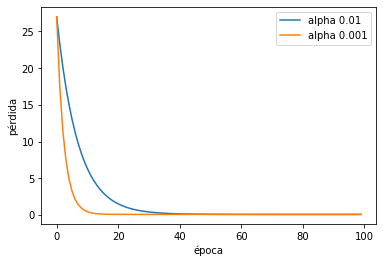

In [451]:
plt.figure()
for k in resultados.keys():
    grafica=resultados[k]["loss"]
    plt.plot(range(len(grafica)), grafica, label=f"alpha {k}")

plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')

podemos observar que una tasa de aprendizaje menor 0.001 converge en la mitad de iteraciones con respecto a la tasa de aprendizaje de 0.01

## 3) Entrena una red completamente conectada para aproximar la compuerta XOR.


In [327]:
def XOR(x,y,lr,epocas):
    model = pt.nn.Sequential(
    nn.Linear(2, 5),
    nn.ReLU(),
    nn.Linear(5, 1))
    optimizer = optim.SGD(model.parameters(), lr=lr)

    for epoca in range(epocas):
        #forward
        y_est = model(X)
        
        #compute mean squared error loss
        loss = mse_loss(y_est, y)

        #backprop the loss gradients
        loss.backward()

        #update the model weights using the gradients
        optimizer.step()

        #empty the gradients for the next iteration
        optimizer.zero_grad()
    return model(X).round()

In [328]:
xor= np.array([[1, 0, 1], [0, 1, 1],
                 [1, 1, 0], [0, 0, 0]], dtype='float32')
x = tensor(xor[:, :2])
y = tensor(xor[:, -1]).reshape(x.shape[0], 1)

Podemos ver que con un learning rate de 0.01 y 100 épocas el modelo clasifca todo como 0

In [331]:
XOR(x=x,y=y,lr=0.01,epocas=100)

tensor([[0.],
        [0.],
        [0.],
        [0.]], grad_fn=<RoundBackward>)

Si aumentamos el número de épocas a 100 el modelo converge a la solucion correcta la cual deberia ser 1 1 0 0 

In [330]:
XOR(x=x,y=y,lr=0.01,epocas=1000)

tensor([[1.],
        [1.],
        [-0.],
        [0.]], grad_fn=<RoundBackward>)

## 4. Entrena una red completamente conectada para clasificación multiclase en el conjunto CIFAR10

### Datos de entrenamiento

In [371]:
tsfm = T.ToTensor()

# creamos un Dataset
trn_ds = CIFAR10(
    # directorio de datos
    root=DATA_DIR,
    # subconjunto de entrenamiento
    train=True,
    # transformación
    transform=tsfm,
    # descaraga
    download=True
)

# creamos un DataLoader
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

Files already downloaded and verified


### Datos de prueba

In [372]:
# creamos un Dataset
tst_ds = CIFAR10(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=False,
    # transformación
    transform=tsfm
)

# creamos un DataLoader
tst_dl = DataLoader(
    # subconjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=False
)

### Definición de la arquitectura

In [379]:
# definición del arquitectura
class CNN(nn.Module):
    
    # inicializador
    def __init__(self):

        # inicilización del objeto padre, obligatorio
        super(CNN, self).__init__()
        self.num_feats = 6 * 16 * 16

        # definición de bloques conv
        # [M, 1, 28, 28] => [M, 4, 14, 14]
        self.cnn = nn.Sequential(

            # bloque conv1
            # [M, 1, 28, 28] => [M, 4, 28, 28]
            nn.Conv2d(in_channels=3, out_channels=6, 
                      kernel_size=3, padding=1),
            # [M, 4, 28, 28]
            nn.ReLU(),
            # [M, 4, 28, 28] => [M, 4, 14, 14]
            nn.MaxPool2d(kernel_size=2, stride=2),

        )       
        
        # [M, 4, 14, 14] => [M, 4x14x14]
        self.flatten = nn.Flatten()

        # [M, 4x14x14] => [M, 1]
        self.cls = nn.Linear(self.num_feats, 10)
    
    # metodo para inferencia
    def forward(self, x):
        # [M, 1, 28, 28] => [M, 4, 14, 14]
        x = self.cnn(x)
        # [M, 4, 14, 14] => [M, 4x14x14]
        x = self.flatten(x)
        # [M, 4x14x14] => [M, 10]
        x = self.cls(x)
        return x

### Instancia de la arquitectura

In [459]:
model = CNN()
print(model)

CNN(
  (cnn): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cls): Linear(in_features=1536, out_features=10, bias=True)
)


In [462]:
x,y=next(iter(tst_ds))

### Inferencia con datos sintéticos

In [465]:
x = torch.zeros(1, 3, 32, 32)
y = model(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 3, 32, 32]) => torch.Size([1, 10])


### Inspacción de la arquitectura

In [466]:
summary(model, (1, 3, 32, 32), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [1, 6, 16, 16]            --
|    └─Conv2d: 2-1                       [1, 6, 32, 32]            168
|    └─ReLU: 2-2                         [1, 6, 32, 32]            --
|    └─MaxPool2d: 2-3                    [1, 6, 16, 16]            --
├─Flatten: 1-2                           [1, 1536]                 --
├─Linear: 1-3                            [1, 10]                   15,370
Total params: 15,538
Trainable params: 15,538
Non-trainable params: 0
Total mult-adds (M): 0.18
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.06
Estimated Total Size (MB): 0.12

### Entrenamiento

In [377]:
def train_epoch(dl, model, opt):

    # por cada lote
    for x, y_true in dl:
        
        # computamos logits
        y_lgts = model(x)
        
        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):

            # computamos los logits
            y_lgts = model(x)

            # computamos los puntajes
            y_prob = F.softmax(y_lgts, 1)

            # computamos la clases
            y_pred = torch.argmax(y_prob, 1)

            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
def train(model, trn_dl, tst_dl, lr=1e-3, epochs=20,
          trn_batches=None, tst_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.SGD(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_acc = eval_epoch(tst_dl, model, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        acc_hist.append([trn_acc, tst_acc])

        # imprimimos progreso
        print(f'E{epoch:02} '
              f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
              f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

    return loss_hist, acc_hist

In [452]:
# instanciamos un modelo
model = CNN()
# entrenamos
loss_hist, acc_hist = train(model, trn_dl, tst_dl,epochs=50)

100%|██████████| 50/50 [19:14<00:00, 23.08s/it]E49 loss=[145.65,148.12] acc=[49.03,47.66]



### Gráficas de pérdidas y exactitud
Gráfica de Pérdida

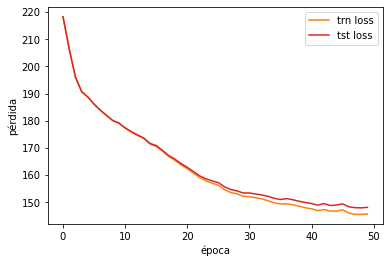

In [453]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

Gráfica de Exactitud

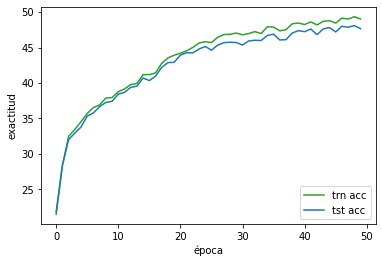

In [454]:
trn_acc, tst_acc = zip(*acc_hist)
plt.plot(trn_acc, 'tab:green', label='trn acc')
plt.plot(tst_acc, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

## Evaluación del Modelo

In [455]:
# evaluamos en entrenamiento
trn_loss, trn_acc = eval_epoch(trn_dl, model)
# evaluamos en prueba
tst_loss, tst_acc = eval_epoch(tst_dl, model)
print(f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
      f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

loss=[145.65,148.12] acc=[49.03,47.66]


In [467]:
with torch.no_grad(): 
    x, y_true = next(iter(tst_dl))
    y_lgts = model(x)
    y_prob = F.softmax(y_lgts, 1)
    y_pred = torch.argmax(y_prob, 1)
    titles = [f'V={t} P={p}' for t, p in zip(y_true, y_pred)]
    #display_batch(x, titles, ROWS, COLS)

In [468]:
titles

['V=3 P=4',
 'V=8 P=8',
 'V=8 P=1',
 'V=0 P=8',
 'V=6 P=8',
 'V=6 P=8',
 'V=1 P=8',
 'V=6 P=8',
 'V=3 P=4',
 'V=1 P=4',
 'V=0 P=8',
 'V=9 P=4',
 'V=5 P=8',
 'V=7 P=8',
 'V=9 P=8',
 'V=8 P=8',
 'V=5 P=8',
 'V=7 P=8',
 'V=8 P=1',
 'V=6 P=8',
 'V=7 P=8',
 'V=0 P=4',
 'V=4 P=8',
 'V=9 P=4',
 'V=5 P=8',
 'V=2 P=8',
 'V=4 P=8',
 'V=0 P=8',
 'V=9 P=4',
 'V=6 P=4',
 'V=6 P=8',
 'V=5 P=8']